In [1]:
pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.6 MB/s 


In [2]:
%load_ext watermark

import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML

import time

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline 
%watermark


Last updated: 2022-12-31T05:31:33.091580+00:00

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 7.9.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.10.133+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



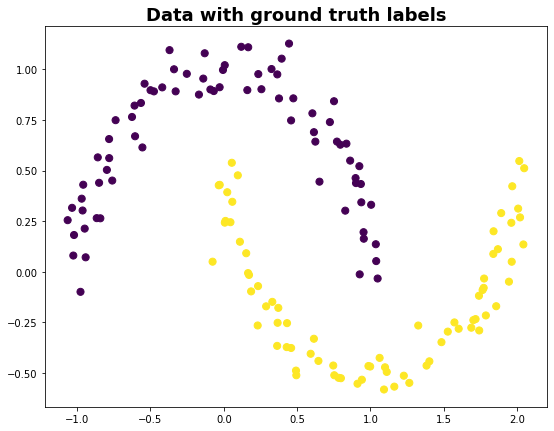

In [3]:
from sklearn.datasets import make_moons
random_state = 2022
X_mn, y_mn = make_moons(150, noise = 0.07, random_state = random_state)
cmap = 'viridis'
dot_size = 50 

fig, ax = plt.subplots(figsize = (9,7))
ax.set_title('Data with ground truth labels', fontsize = 18, fontweight = 'demi')

ax.scatter(X_mn[:, 0], X_mn[:, 1], c = y_mn, s = dot_size, cmap = cmap)


A K-Means won't help here since the cluster aren't spherical.
Here is an example of trying to solve this clustering problem using K-Means algorithm.

In [4]:
from sklearn.cluster import KMeans

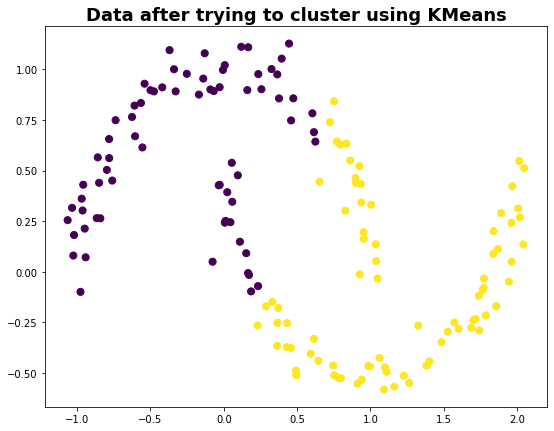

In [5]:
kmeans = KMeans(n_clusters = 2, random_state = 0).fit(X_mn)
fig,ax = plt.subplots(figsize = (9,7))
ax.set_title('Data after trying to cluster using KMeans', fontSize = 18, fontweight = 'demi')

ax.scatter(X_mn[:, 0], X_mn[:, 1], c = kmeans.labels_, s = dot_size, cmap = cmap)

First, let's create similarity graph.

In [6]:
from sklearn.neighbors import radius_neighbors_graph
from sklearn.neighbors import kneighbors_graph

In [7]:
A = radius_neighbors_graph(X_mn, 0.4, mode = 'distance', metric = 'minkowski', p = 2, metric_params = None, include_self = False)
#This function help us to compute the weighted graph of neighbors for points in X_mn
#Neighborhood are restricted the points at the distance lower than radius.
#Or you can use K-neighbors graph
#A = kneighbors_graph(X_mn, 2, mode = 'connectivity', metric = 'minkowski', p = 2, metric_params = None, include_self = False)
#This function help us to compute weighted graph of k-Neighbors for points in X_mn
A = A.toarray() #convert A to array
A.shape 

(150, 150)

Let's see the adjacency matrix of the first 5 point.

In [8]:
A[:5, :5]

array([[0.        , 0.        , 0.        , 0.20853254, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.20853254, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

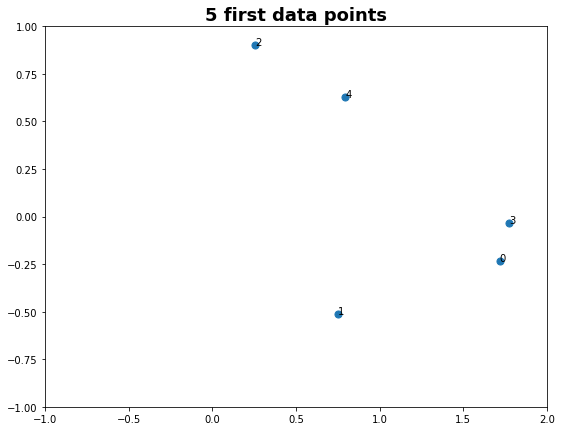

In [9]:
fig, ax = plt.subplots(figsize = (9,7))
ax.set_title('5 first data points', fontsize = 18, fontweight = 'demi')
ax.set_xlim(-1,2)
ax.set_ylim(-1,1)
ax.scatter(X_mn[:5, 0], X_mn[:5, 1], s = dot_size, cmap = cmap)
for i in range(5):
  ax.annotate(i, (X_mn[i, 0], X_mn[i, 1]))

As we can see, point 3 and point 0 are very close so the weight is 0.2085. But point 1 and point are far away so the weight is 0.

Next, let's make Laplacian Matrix.
The Laplacian is defined as the L=D-A where A is our adjecency matrix we just saw and D is a diagonal matrix.
D is the "degree matrix" , every cell in the diagonal is the sum of the weights for that point.

In [10]:
#Use built-in function to make Laplacian matrix
from scipy.sparse import csgraph
L = csgraph.laplacian(A, normed = False)


In [11]:
L[:5, :5]

array([[ 3.88465661, -0.        , -0.        , -0.20853254, -0.        ],
       [-0.        ,  4.08664421, -0.        , -0.        , -0.        ],
       [-0.        , -0.        ,  4.2859028 , -0.        , -0.        ],
       [-0.20853254, -0.        , -0.        ,  4.74920559, -0.        ],
       [-0.        , -0.        , -0.        , -0.        ,  3.94122294]])

So I used the built in function of scipy for laplacian, as you can see the Laplacian values on the diagonal are the degree matrix, and the rest are the weights from the adjacency matrix with the minus sign due to our formula.

Next we are going to embed the data points in a low dimensional space(spectral embedding), in which the clusters are more obvious with the use of eigenvectors of the graph laplacian.

In [12]:
#Compute the eigenvalues and right eigenvectors 
eigval, eigvec = np.linalg.eig(L)
kmeans = KMeans(n_clusters = 2, random_state = 0).fit(eigvec)

In [13]:
np.where(eigval == np.partition(eigval, 1)[1])

(array([1]),)

In [14]:
eigval[:20]

array([4.57966998e-16, 2.97652012e-02, 1.55066642e-01, 1.41482529e-01,
       4.81182922e-01, 5.80875169e-01, 6.66605942e+00, 1.12792732e+00,
       1.22230602e+00, 6.45166619e+00, 6.30435075e+00, 1.50983368e+00,
       5.98685952e+00, 5.97247630e+00, 5.88023560e+00, 5.85353553e+00,
       5.80243949e+00, 5.75503930e+00, 1.64125905e+00, 1.82455332e+00])

In [15]:
eigvec[3]

array([-8.16496581e-02, -9.99514017e-02,  1.25396144e-01,  1.11712310e-02,
       -2.59183185e-02, -3.96786805e-02,  1.07583944e-01,  3.97392406e-02,
        9.97917249e-03, -6.04374217e-04,  7.93081879e-02,  7.91708728e-02,
       -3.57599145e-02, -8.39125710e-03,  2.26076687e-02,  2.63238571e-01,
       -5.77067239e-03,  2.40477332e-01,  9.03817475e-03,  1.95667223e-02,
       -8.73787798e-03, -9.19650121e-04, -1.90365282e-04,  1.11715304e-03,
        4.58992557e-03,  4.51210134e-04,  5.52332491e-02, -1.68611728e-01,
        1.61699249e-01, -1.40213418e-01,  3.38956861e-02,  7.04725865e-03,
        3.74393129e-02, -4.94215395e-02, -2.14492607e-03,  9.13681115e-03,
        1.19890918e-01,  4.43855310e-02,  1.35603383e-02, -2.14756172e-03,
        1.15792093e-01,  2.69231479e-02, -1.75674760e-01, -6.61113993e-03,
       -2.76941389e-04, -4.24542244e-03,  1.33169260e-03, -7.85688351e-03,
        2.29842219e-04, -1.97666758e-01,  1.82584936e-02,  1.33032900e-01,
        4.54125171e-01,  

In [16]:
y_spec = eigvec[:, 1].copy()
y_spec[y_spec < 0] = 0
y_spec[y_spec > 0] = 1

In [17]:
type(y_spec), y_mn.shape, y_spec.shape

(numpy.ndarray, (150,), (150,))

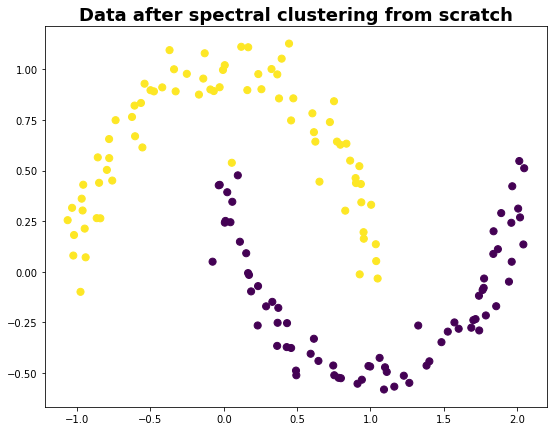

In [18]:
fig, ax = plt.subplots(figsize = (9, 7))
ax.set_title('Data after spectral clustering from scratch', fontsize = 18, fontweight = 'demi')
ax.scatter(X_mn[:, 0], X_mn[:, 1], c = y_spec, s = dot_size, cmap = cmap)

Let's compare with Spectral Clustering built-in function


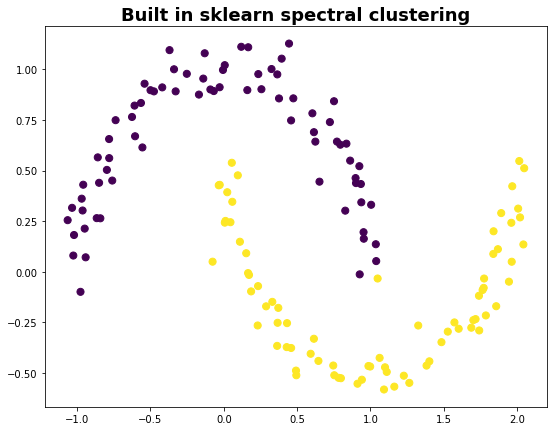

In [19]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors', assign_labels = 'kmeans')
labelsS = model.fit_predict(X_mn)
fig, ax = plt.subplots(figsize = (9, 7))
ax.set_title('Built in sklearn spectral clustering', fontsize = 18, fontweight = 'demi')
plt.scatter(X_mn[:, 0], X_mn[:, 1], c = labelsS, s = dot_size, cmap = cmap)

Nearly the same!!!